# Library & Dataset

Load Time_series Dataset and Socar Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import datetime
import math

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline

import requests
import json
import folium



In [3]:
### Load Time Series Dataset

timeseries_path = os.path.join(os.getcwd(), "drive", "MyDrive",  "Colab Notebooks", "data", "timeseries_all_months.csv")
timeseries = pd.read_csv(timeseries_path)
timeseries = timeseries.drop(columns=["Unnamed: 0"])
timeseries["time"] = pd.to_datetime(timeseries["time"])
#timeseries

In [4]:
#timeseries["zone"].value_counts()

In [5]:
### Load Socar Raw Dataset(##Socar Hackathon 2번째 수정파일 75만건-수정본)

socar_eta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/tada_eta2.csv') 


# Data Cleansing & Pre-Processing# 

In [6]:
### 데이터 전처리(Time 분류)

socar_eta['Day'] = pd.to_datetime(socar_eta['reservation_return_at'])
socar_eta['Day2'] = pd.to_datetime(socar_eta['reservation_start_at'])
socar_eta['Month'] = pd.to_datetime(socar_eta['reservation_start_at']).dt.month
socar_eta['Date'] = pd.to_datetime(socar_eta['reservation_start_at']).dt.day
socar_eta['weekend'] = pd.to_datetime(socar_eta['reservation_start_at']).dt.day_name()
socar_eta['start_hour'] = pd.to_datetime(socar_eta['reservation_start_at']).dt.hour
socar_eta['member_created_year'] = pd.to_datetime(socar_eta['member_created_date']).dt.year

time_a=(socar_eta['Month'])*100 
socar_eta['TC']=time_a+socar_eta['Date']  #날짜별 데이터 정리...

### 대여시간 계산
socar_eta['Diff_1'] = np.round(((socar_eta['Day'] - socar_eta['Day2']).astype('timedelta64[m]'))/60) 

In [7]:
### 지역 서울로 한정

seoul_data = socar_eta[socar_eta["region"].str.contains("서울특별시")]
seoul_data.head(5)

,reservation_id,car_id,member_id_encrypted,region,reservation_return_at,reservation_start_at,member_age,member_gender,member_created_date,member_total_distance,is_vroom,car_name,zone_name,zone_address,zone_lat,zone_lng,zone_type1,zone_type2,zone_type3,reservation_created_lat,reservation_created_lng,trip,Day,Day2,Month,Date,weekend,start_hour,member_created_year,TC,Diff_1
0,19600422,8352,6qA1i9+DXTJYgfWPqSGhszRpgNkUzFATBTG4XG7OciA=,서울특별시 강서구,2019-01-01 17:33:42,2018-12-31 17:30:00,48,male,2016-12-10,2277.0,False,아반떼AD,SK주차장,서울 강서구 방화동 500-8,37.573011,126.804605,LIVING_APT,TRANSFER_STATION,TRANSFER_SUBWAY,NaN,NaN,NaN,2019-01-01 17:33:42,2018-12-31 17:30:00,12,31,Monday,17,2016,1231,24.0
4,19728911,8809,gdP+78Hhm+MZ4ZxIm8kNVvMNzKJBxbiDfBsflsMcwLA=,서울특별시 강서구,2019-01-04 14:06:03,2019-01-03 08:00:00,35,male,2017-08-13,2658.0,False,투싼(경유),용정주차장,서울 강서구 방화동 608-9,37.565186,126.816185,LIVING_ETC,TRANSFER_SUBWAY,ETC,NaN,NaN,NaN,2019-01-04 14:06:03,2019-01-03 08:00:00,1,3,Thursday,8,2017,103,30.0
5,19736553,11030,QC0bcULiIjIaUq+C+0meIx+XFzDRCDGgdi24wO3w5eo=,서울특별시 강남구,2019-01-01 17:32:30,2018-12-29 15:00:00,28,male,2016-03-13,3398.0,False,그랜저IG (LPG),제일주차장,서울 강남구 대치동 1000-6,37.507687,127.066147,TRANSFER_SUBWAY,COMMERCIAL_OFFICE,COMMERCIAL_HOTSPOT,NaN,NaN,NaN,2019-01-01 17:32:30,2018-12-29 15:00:00,12,29,Saturday,15,2016,1229,75.0
7,19753691,13056,7dux47JcwKUjvwLd0EJsFU4lYuiR2IxlSQzgRclvlac=,서울특별시 강서구,2019-01-01 16:17:40,2019-01-01 12:00:00,26,male,2016-08-09,1655.0,False,클리오,웨스트엔드 3차,서울 강서구 내발산동 750-10,37.553017,126.826775,LIVING_APT,COMMERCIAL_HOTSPOT,ETC,NaN,NaN,NaN,2019-01-01 16:17:40,2019-01-01 12:00:00,1,1,Tuesday,12,2016,101,4.0
9,19765874,11437,9+D2izvRSnkRWLWjrIGiEVcFkxH6GZ/fZmMj7tEE6s8=,서울특별시 강서구,2019-01-03 19:51:13,2019-01-03 18:10:00,32,NaN,2016-10-25,92.0,False,더뉴레이,SK주차장,서울 강서구 방화동 500-8,37.573011,126.804605,LIVING_APT,TRANSFER_STATION,TRANSFER_SUBWAY,NaN,NaN,NaN,2019-01-03 19:51:13,2019-01-03 18:10:00,1,3,Thursday,18,2016,103,2.0


## Resampling

Change time_series sampling period

In [8]:
ts=timeseries

In [9]:
ts=ts.set_index('time')

In [10]:
ts.shape

(3519024, 3)

In [11]:
ts

,zone,n_drive,n_drive_unique
time,,,
2019-01-01 00:00:00,SK주차장,12.0,12.0
2019-01-01 00:00:00,용정주차장,1.0,1.0
2019-01-01 00:00:00,제일주차장,5.0,5.0
2019-01-01 00:00:00,웨스트엔드 3차,3.0,3.0
2019-01-01 00:00:00,도곡로21길7 공영주차장,2.0,2.0
...,...,...,...
2019-11-30 23:00:00,마곡 747타워,0.0,0.0
2019-11-30 23:00:00,우덕빌딩,0.0,0.0
2019-11-30 23:00:00,COCOON DONGDUK_A 빌라 주차장,0.0,0.0


In [12]:
### 1일 단위로 Resampling

ts_resample= pd.DataFrame()
ts_resample['n_drive_1day'] = ts.groupby('zone').n_drive.resample('1D').max() 

In [13]:
ts_resample.reset_index(inplace = True)


In [14]:
ts_resample

,zone,time,n_drive_1day
0,88주차장,2019-01-01,5.0
1,88주차장,2019-01-02,4.0
2,88주차장,2019-01-03,5.0
3,88주차장,2019-01-04,3.0
4,88주차장,2019-01-05,5.0
...,...,...,...
146287,힐스테이트에코마곡나루역오피스텔,2019-11-26,0.0
146288,힐스테이트에코마곡나루역오피스텔,2019-11-27,1.0
146289,힐스테이트에코마곡나루역오피스텔,2019-11-28,1.0
146290,힐스테이트에코마곡나루역오피스텔,2019-11-29,1.0


# **Modeling**

In [15]:
### Input Data Type 변경

ts_resample.rename(columns={'time':'ds', 'n_drive_1day':'y'}, inplace=True)

In [16]:
ts_resample

,zone,ds,y
0,88주차장,2019-01-01,5.0
1,88주차장,2019-01-02,4.0
2,88주차장,2019-01-03,5.0
3,88주차장,2019-01-04,3.0
4,88주차장,2019-01-05,5.0
...,...,...,...
146287,힐스테이트에코마곡나루역오피스텔,2019-11-26,0.0
146288,힐스테이트에코마곡나루역오피스텔,2019-11-27,1.0
146289,힐스테이트에코마곡나루역오피스텔,2019-11-28,1.0
146290,힐스테이트에코마곡나루역오피스텔,2019-11-29,1.0


In [17]:
### Holiday 영향 반영을 위한 휴일 정보 입력

holidays = pd.DataFrame({
  'holiday': 'national',
  'ds': pd.to_datetime(['2019-01-01', '2019-02-04', '2019-02-05',
                        '2019-02-06', '2019-03-01', '2019-05-06',
                        '2019-06-06', '2019-08-15', '2019-09-12',
                        '2019-09-13', '2019-09-14', '2019-10-03',
                        '2019-10-09', '2019-12-25', '2019-05-01']),

### Holiday 전날도 포함

  'lower_window': -1,
  'upper_window': 0,
})
holidays

,holiday,ds,lower_window,upper_window
0,national,2019-01-01,-1,0
1,national,2019-02-04,-1,0
2,national,2019-02-05,-1,0
3,national,2019-02-06,-1,0
4,national,2019-03-01,-1,0
5,national,2019-05-06,-1,0
6,national,2019-06-06,-1,0
7,national,2019-08-15,-1,0
8,national,2019-09-12,-1,0
9,national,2019-09-13,-1,0


In [18]:
Train = False

In [19]:
zone_number=len(ts_resample.zone.unique())

In [20]:
### prophet 모델링을 사용한 예측

period=1
group_yhat=list()
group_yhat_lower=[]
group_yhat_upper=[]
group_ds=[]

y_reals = []
y_preds = []
zone = []

index_zone=ts_resample.zone.unique()[:zone_number]
### 서울 전체 쏘카 존에서 시행(n=438)

for i in tqdm(index_zone): 
    sample = ts_resample[ts_resample.zone ==i].copy()
#    sample.drop('zone',axis=1,inplace=True)
#    print(sample)

    if Train :
        sample['ds'] = pd.to_datetime(sample['ds'])
        sample.index= sample['ds']
        sample.columns = ['ds','y']
        
        answer = sample.last('60D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
    else :
        sample['ds'] = pd.to_datetime(sample['ds'])
        sample.columns = ['zone','ds','y']
        test= sample
        
    m = Prophet(changepoint_prior_scale=0.8,

      yearly_seasonality=False,
      weekly_seasonality=True,
      daily_seasonality = True,
     # seasonality_prior_scale = 0.2,
      holidays=holidays)
    
    m.fit(test)
    
    # 예측기간(30일로 set)
    future = m.make_future_dataframe(periods=30)    
    forecast = m.predict(future)
    new = forecast[['trend','ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(period)
    new.append(new,ignore_index=True)
    group_yhat.append(new["yhat"])
    group_yhat_upper.append(new["yhat_upper"])
    group_yhat_lower.append(new["yhat_lower"])
    group_ds.append(new["ds"])
    y_pred = forecast.iloc[-30:, :].yhat.sum()
    y_preds.append(y_pred)
    zone.append(i)

    # 시각화부분
    #fig1 = m.plot(forecast)
    #plt.show()



  0%|          | 0/438 [00:00<?, ?it/s]

## **Growth rate**

In [21]:
### Model의 예측값 Type변환

group_ds2=pd.DataFrame(group_ds,index=index_zone)
group_yhat2=pd.DataFrame(group_yhat,index=index_zone)
group_yhat_upper2=pd.DataFrame(group_yhat_upper,index=index_zone)
group_yhat_lower2=pd.DataFrame(group_yhat_lower,index=index_zone)


In [22]:
### Zone별 Model의 예측결과

group_prophet=pd.concat([group_ds2,group_yhat2,group_yhat_upper2,group_yhat_lower2],axis=1)
group_prophet.columns=['time','yhat','yhat_upper','yhat_lower']
group_prophet

,time,yhat,yhat_upper,yhat_lower
88주차장,2019-12-30,3.146803,4.799503,1.647246
AJ파크 논현점,2019-12-30,0.092828,1.448694,-1.266705
AJ파크 장안점(덕원주차장),2019-12-30,-0.034805,0.771051,-0.888036
COCOON DONGDUK_A 빌라 주차장,2019-12-30,0.436705,0.580437,0.302046
CU 마곡아르디에점(운영종료),2019-12-30,0.008619,0.211988,-0.191854
...,...,...,...,...
휘경여자중학교 앞,2019-12-30,-0.149033,0.303987,-0.616958
힐스테이트상가,2019-12-30,4.657224,6.818502,2.322946
힐스테이트에코동익 오피스텔 103동,2019-12-30,2.818954,3.585611,1.976594
힐스테이트에코마곡나루역 오피스텔,2019-12-30,2.277536,4.217759,0.242591


In [23]:
ts_resample

,zone,ds,y
0,88주차장,2019-01-01,5.0
1,88주차장,2019-01-02,4.0
2,88주차장,2019-01-03,5.0
3,88주차장,2019-01-04,3.0
4,88주차장,2019-01-05,5.0
...,...,...,...
146287,힐스테이트에코마곡나루역오피스텔,2019-11-26,0.0
146288,힐스테이트에코마곡나루역오피스텔,2019-11-27,1.0
146289,힐스테이트에코마곡나루역오피스텔,2019-11-28,1.0
146290,힐스테이트에코마곡나루역오피스텔,2019-11-29,1.0


In [24]:
### Zone별 기존 운영 Data

ts_before=pd.DataFrame()

ts_before['n_drive_max'] = ts_resample.groupby('zone').y.max()
ts_before['n_drive_min'] = ts_resample.groupby('zone').y.min()
ts_before['n_drive_avg'] = ts_resample.groupby('zone').y.mean()
ts_before2=ts_before[:zone_number]

In [25]:
group_prophet=pd.concat([group_prophet,ts_before2],axis=1)

In [26]:
group_prophet['growth'] = (group_prophet['yhat_upper'] - group_prophet['n_drive_avg'])


In [27]:
group_prophet.sort_values('growth',ascending=False, inplace=True)
group_prophet

,time,yhat,yhat_upper,yhat_lower,n_drive_max,n_drive_min,n_drive_avg,growth
zone,,,,,,,,
코엑스 옥상주차장,2019-12-30,19.217171,24.899803,14.442420,33.0,0.0,15.455090,9.444714
롯데백화점 청량리점 주차장,2019-12-30,7.397425,9.763644,5.086236,15.0,0.0,1.979042,7.784602
호텔뉴브,2019-12-30,7.181895,8.029606,6.402871,5.0,0.0,0.374251,7.655355
외대앞역 공영주차빌딩 옥외주차장,2019-12-30,10.246997,13.080469,7.110969,12.0,0.0,5.901198,7.179271
발산파크프라자,2019-12-30,14.657485,19.226923,9.961418,39.0,0.0,12.634731,6.592192
...,...,...,...,...,...,...,...,...
서울 아현역 1번출구[V],2019-12-30,-0.651019,3.451442,-4.793151,19.0,0.0,6.748503,-3.297061
SK주차장,2019-12-30,19.993974,27.590049,11.780579,67.0,7.0,31.293413,-3.703364
발산역 9번출구,2019-12-30,-1.912990,1.416095,-5.225573,19.0,0.0,5.586826,-4.170731


# **Clustering**

In [28]:
Z=pd.DataFrame()
Z=pd.concat([group_prophet["n_drive_avg"],group_prophet["growth"]],axis=1)

In [29]:
Z.reset_index(inplace=True)

In [30]:
### Clustering 보정

### Y축 보정
Z['growth']  = np.where(Z['growth'] >=2 , 2, Z['growth'])
Z['growth']  = np.where(Z['growth'] <=-1 , -1, Z['growth'])

### X축 보정
Z['n_drive_avg']  = np.where(Z['n_drive_avg'] >=3 , 3, Z['n_drive_avg'])

In [31]:
Z

,zone,n_drive_avg,growth
0,코엑스 옥상주차장,3.000000,2.0
1,롯데백화점 청량리점 주차장,1.979042,2.0
2,호텔뉴브,0.374251,2.0
3,외대앞역 공영주차빌딩 옥외주차장,3.000000,2.0
4,발산파크프라자,3.000000,2.0
...,...,...,...
433,서울 아현역 1번출구[V],3.000000,-1.0
434,SK주차장,3.000000,-1.0
435,발산역 9번출구,3.000000,-1.0
436,회기역(베라체캠퍼스),3.000000,-1.0


In [32]:
### zone name 별도 추출

z_name=pd.DataFrame()
z_name=Z["zone"]

In [33]:
### Clustering 위한 작업

Z.drop('zone',axis=1,inplace=True)
#Z

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(12.425000000000011, 0.5, 'y')

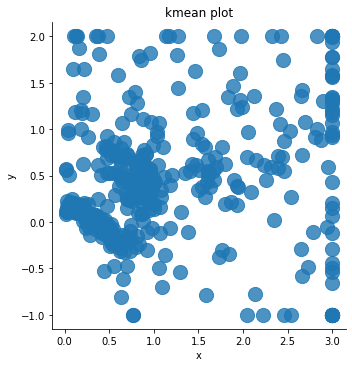

In [34]:
sns.lmplot('n_drive_avg', 'growth', data=Z, fit_reg=False, scatter_kws={"s": 200}) # x-axis, y-axis, data, no line, marker size

# title
plt.title('kmean plot')

# x-axis label
plt.xlabel('x')

# y-axis label
plt.ylabel('y')


In [35]:
data_points = Z.values
kmeans = KMeans(n_clusters=4).fit(data_points)


In [36]:
kmeans.labels_


array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 2, 0, 2, 3, 3, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2,

In [37]:
kmeans.cluster_centers_


array([[ 0.89091597,  0.73381558],
       [ 2.62470298,  1.35192964],
       [ 0.42616766,  0.01394453],
       [ 2.57624286, -0.40378052]])

In [38]:
Z['cluster_id'] = kmeans.labels_


In [39]:
Z.head(5)


,n_drive_avg,growth,cluster_id
0,3.000000,2.0,1
1,1.979042,2.0,1
2,0.374251,2.0,0
3,3.000000,2.0,1
4,3.000000,2.0,1


Text(0.5, 1.0, 'Socar Zone K-Means Clustering Result')

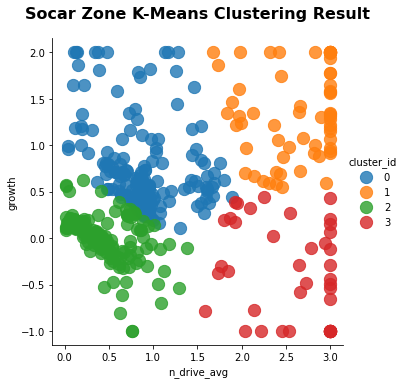

In [40]:
sns.lmplot(x='n_drive_avg', y='growth', data=Z, fit_reg=False,  # x-axis, y-axis, data, no line
           scatter_kws={"s": 150}, # marker size
           hue="cluster_id") # color

# title
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}

plt.title('Socar Zone K-Means Clustering Result',fontdict=title_font, pad=20)


### **Clustering 결과 분석**

In [41]:
Z

,n_drive_avg,growth,cluster_id
0,3.000000,2.0,1
1,1.979042,2.0,1
2,0.374251,2.0,0
3,3.000000,2.0,1
4,3.000000,2.0,1
...,...,...,...
433,3.000000,-1.0,3
434,3.000000,-1.0,3
435,3.000000,-1.0,3
436,3.000000,-1.0,3


In [42]:
z_name = pd.concat([z_name,Z],axis=1)

In [43]:
z_name.query("cluster_id==3").head(3)

,zone,n_drive_avg,growth,cluster_id
197,포이초교 공영주차장,2.251497,0.447187,3
203,까치주차장,3.000000,0.430836,3
217,방화동성아파트 주차장,1.928144,0.389515,3


In [44]:
### 운영종료존이 어떤 cluster에 속해있는지?

z_rs = z_name[z_name["zone"].str.contains('운영종료')]
z_rs.tail(10)

,zone,n_drive_avg,growth,cluster_id
357,서대문우체국 뒤(운영종료),0.266467,-0.043676,2
358,논현역 2번출구(대니하우스)(운영종료),0.350299,-0.047801,2
362,역삼동(강남주차장)(운영종료),0.377246,-0.062673,2
366,신촌기차역입구교차로 옆(운영종료),0.335329,-0.071374,2
374,역삼역 8번출구(포스트빌)(운영종료),0.428144,-0.110869,2
377,역삼역 3번출구(강남역두산위브센티움)(운영종료),0.413174,-0.119082,2
379,강신초등학교 옆(운영종료),0.287425,-0.138802,2
382,논현 영동시장 입구(운영종료),0.814371,-0.151259,2
387,장안동사거리(운영종료),0.583832,-0.197870,2
393,강남지웰파인즈 오피스텔(운영종료),0.508982,-0.262897,2


In [45]:
### zone별 운행시간값 가져오기

zone_drive_hours=[]

#(len(z_name.zone.unique())+1)
for i in tqdm(z_name.zone.unique()[:zone_number]):
    sample = z_name[z_name.zone ==i]
    zone_lt=seoul_data.Diff_1[seoul_data['zone_name'].isin(sample["zone"])].sum()
    zone_drive_hours.append(zone_lt)

  0%|          | 0/438 [00:00<?, ?it/s]

In [46]:
### 데이터 변환

zone_drive_hours=pd.DataFrame(zone_drive_hours)
zone_drive_hours.columns=['zone_drive_hours']

In [47]:
### zone별 운행시간값 입력

z_hour_added=pd.concat([z_name,zone_drive_hours],axis=1)
z_hour_added

,zone,n_drive_avg,growth,cluster_id,zone_drive_hours
0,코엑스 옥상주차장,3.000000,2.0,1,79687.0
1,롯데백화점 청량리점 주차장,1.979042,2.0,1,9354.0
2,호텔뉴브,0.374251,2.0,0,1532.0
3,외대앞역 공영주차빌딩 옥외주차장,3.000000,2.0,1,21985.0
4,발산파크프라자,3.000000,2.0,1,67176.0
...,...,...,...,...,...
433,서울 아현역 1번출구[V],3.000000,-1.0,3,31874.0
434,SK주차장,3.000000,-1.0,3,166714.0
435,발산역 9번출구,3.000000,-1.0,3,24115.0
436,회기역(베라체캠퍼스),3.000000,-1.0,3,12727.0


In [48]:
### 파일 저장
#z_hour_added.to_csv("/content/drive/MyDrive/Colab Notebooks/data/zone_cluster_id.csv")

Clustering별 대여시간 비교

In [49]:
### Cluster존별 ID 맵핑

cl_info=pd.DataFrame(columns=['cluster_name','cluster_id'])
cl_info['cluster_name']=['Point','Super','End','Target']
cl_info['cluster_id']=[0,1,2,3]

cl_info

,cluster_name,cluster_id
0,Point,0
1,Super,1
2,End,2
3,Target,3


In [50]:
 cluster_hour_sum=pd.DataFrame(z_hour_added.groupby('cluster_id').zone_drive_hours.sum())
 #cluster_hour_sum

In [51]:
cluster_hour_sum=pd.concat([cl_info,cluster_hour_sum],axis=1)
cluster_hour_sum

,cluster_name,cluster_id,zone_drive_hours
0,Point,0,507508.0
1,Super,1,898786.0
2,End,2,177634.0
3,Target,3,744973.0


Clustering별 존 카운트

In [52]:
cl_num=z_hour_added['cluster_id'].value_counts()
cl_num=pd.DataFrame(cl_num).reset_index()
cl_num.columns=['cluster_id','cluster_count']
cl_num.sort_values('cluster_id',inplace=True)
cl_num.set_index('cluster_id',inplace=True)
#cl_num

In [53]:
cluster_count=pd.concat([cl_info,cl_num],axis=1)
cluster_count

,cluster_name,cluster_id,cluster_count
0,Point,0,182
1,Super,1,63
2,End,2,150
3,Target,3,43


# **Mapping Visualization**

In [54]:
### zone별 GPS 좌표 가져오기

zone_lat2=[]
zone_lng2=[]
#(len(z_name.zone.unique())+1)
for i in tqdm(z_name.zone.unique()[:440]):
    sample = z_name[z_name.zone ==i]
    zone_lt=seoul_data.zone_lat[seoul_data['zone_name'].isin(sample["zone"])].mean()
    zone_lat2.append(zone_lt)
    zone_lt=seoul_data.zone_lng[seoul_data['zone_name'].isin(sample["zone"])].mean()
    zone_lng2.append(zone_lt)

  0%|          | 0/438 [00:00<?, ?it/s]

In [55]:
### 데이터 변환

zone_lat2=pd.DataFrame(zone_lat2)
zone_lng2=pd.DataFrame(zone_lng2)

In [56]:
z_gps=pd.concat([zone_lat2,zone_lng2],axis=1)
z_gps.columns=['zone_lat','zone_lng']

In [57]:
z_name_total=pd.concat([z_name,z_gps],axis=1)

In [58]:
z_name_total

,zone,n_drive_avg,growth,cluster_id,zone_lat,zone_lng
0,코엑스 옥상주차장,3.000000,2.0,1,37.512058,127.058217
1,롯데백화점 청량리점 주차장,1.979042,2.0,1,37.581260,127.049158
2,호텔뉴브,0.374251,2.0,0,37.503138,127.049163
3,외대앞역 공영주차빌딩 옥외주차장,3.000000,2.0,1,37.595203,127.062729
4,발산파크프라자,3.000000,2.0,1,37.559189,126.836557
...,...,...,...,...,...,...
433,서울 아현역 1번출구[V],3.000000,-1.0,3,37.558116,126.955615
434,SK주차장,3.000000,-1.0,3,37.573011,126.804605
435,발산역 9번출구,3.000000,-1.0,3,37.559126,126.836366
436,회기역(베라체캠퍼스),3.000000,-1.0,3,37.590836,127.056213


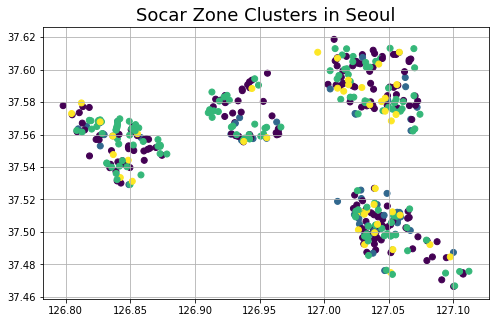

In [59]:
### Clustering 

plt.figure(figsize=(8,5))
plt.title("Socar Zone Clusters in Seoul", fontsize=18)
plt.grid(True)
plt.scatter(z_name_total['zone_lng'], z_name_total['zone_lat'], c=z_name_total['cluster_id'])
plt.show()

## **background mapping**

In [60]:
!pip install folium

In [61]:
map_osm = folium.Map(location=[37.5, 127], zoom_start=12)

for index, row in z_name_total.iterrows():
    location = (row['zone_lat'], row['zone_lng'])
    
    if row['cluster_id']==3:  # Target Zone
      folium.Marker(location, popup=row['zone'],icon = folium.Icon(color='purple', icon='circle')).add_to(map_osm)

    if row['cluster_id']==2:  # End Zone 
      folium.Marker(location, popup=row['zone'],icon = folium.Icon(color='gray', icon='circle')).add_to(map_osm)

    if row['cluster_id']==1:  # Super_socar Zone
      folium.Marker(location, popup=row['zone'],icon = folium.Icon(color='orange', icon='star')).add_to(map_osm)

    if row['cluster_id']==0:  # Point Zone
      folium.Marker(location, popup=row['zone']).add_to(map_osm)


map_osm

